In [1]:
import sys  
sys.path.insert(1, '../')
# from utils.dataset_utils import OriginalDataset
import torch
print(torch.cuda. get_device_name(torch.cuda.current_device()))

NVIDIA GeForce RTX 4080


In [2]:
import os
from utils.dataset_utils import read_img, get_storage
from torchvision.datasets import VisionDataset
import numpy as np

def norm_value(s):
    # return (s + 255.0) / 510.0
    return s / 255

def denorm_value(s):
    # return (s * 510.0) - 255.0
    # print(f"{s = }")
    return torch.tensor(s * 255, dtype=torch.int8)

class OriginalDataset(VisionDataset):
    def __init__(self, data_path: str, color: bool=True):
        super(OriginalDataset, self).__init__()
        self.data_path = data_path
        self.color = color

    def __getitem__(self, idx: int):
        """
        this dataset returns the image corresponding to the index
        """

        if idx >= len(self) or idx < 0:
            # needed for iterator stop condition
            raise IndexError
        # the img_file_path existence check
        img_path = f'{self.data_path}/idx_{idx}.png'
        img2_path = f'{self.data_path}/idx_{idx+1}.png'
        assert os.path.exists(img_path), f"Invalid img_path: {img_path} in {self.data_path}"
        img1 = read_img(img_path, self.color)
        # img2 = read_img(img2_path, self.color)
        img1 = np.array(img1, dtype = np.float32)
        # img2 = np.array(img2, dtype = np.float32)
        # return norm_value(img2 - img1)
        return norm_value(img1)

    def __len__(self) -> int:
        dirpath, dir_names, files = next(os.walk(self.data_path))
        # return len([i for i in files if "resize" not in i]) - 1
        return len([i for i in files if "resize" not in i])

    def __str__(self):
        return f"OriginalDataset({self.data_path})"

    def get_storage_size(self, num_images):
        "returns the total storage size of the dataset"
        total_storage = 0
        for data in [self[i] for i in range(num_images)]:
            total_storage += get_storage(data)
        return total_storage

In [3]:
original_dataset = OriginalDataset('../datasets/droid_100_sample_pictures')
len_ = (original_dataset.__len__())
print(len_)

166


In [4]:
original_dataset[0].shape

(180, 320, 3)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import math
from autoencoder import CNNAutoencoder



Training the model

In [18]:
model = CNNAutoencoder()
model.fit(original_dataset, checkpoint="../checkpoints/autoencoder_28000.pt")

Epoch [ 1/500], Loss: 0.003464
Epoch [ 2/500], Loss: 0.001217
Epoch [ 3/500], Loss: 0.001145
Epoch [ 4/500], Loss: 0.001126
Epoch [ 5/500], Loss: 0.001115
Epoch [ 6/500], Loss: 0.001107
Epoch [ 7/500], Loss: 0.001102
Epoch [ 8/500], Loss: 0.001099
Epoch [ 9/500], Loss: 0.001096
Epoch [10/500], Loss: 0.001094
Epoch [11/500], Loss: 0.001092
Epoch [12/500], Loss: 0.001092
Epoch [13/500], Loss: 0.001090
Epoch [14/500], Loss: 0.001090
Epoch [15/500], Loss: 0.001095
Epoch [16/500], Loss: 0.001091
Epoch [17/500], Loss: 0.001089
Epoch [18/500], Loss: 0.001102
Epoch [19/500], Loss: 0.001089
Epoch [20/500], Loss: 0.001091
Epoch [21/500], Loss: 0.001093
Epoch [22/500], Loss: 0.001115
Epoch [23/500], Loss: 0.001094
Epoch [24/500], Loss: 0.001103
Epoch [25/500], Loss: 0.001112
Epoch [26/500], Loss: 0.001093
Epoch [27/500], Loss: 0.001112
Epoch [28/500], Loss: 0.001100
Epoch [29/500], Loss: 0.001102
Epoch [30/500], Loss: 0.001121
Epoch [31/500], Loss: 0.001096
Epoch [32/500], Loss: 0.001120
Epoch [3

/tmp/ipykernel_2238689/3076756164.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(s * 255, dtype=torch.int8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128..127].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128..127].


torch.Size([1, 8, 39, 74])
tensor([16, 32, 58], dtype=torch.int8)
tensor([21, 43, 56], dtype=torch.int8)


(-0.5, 319.5, 179.5, -0.5)

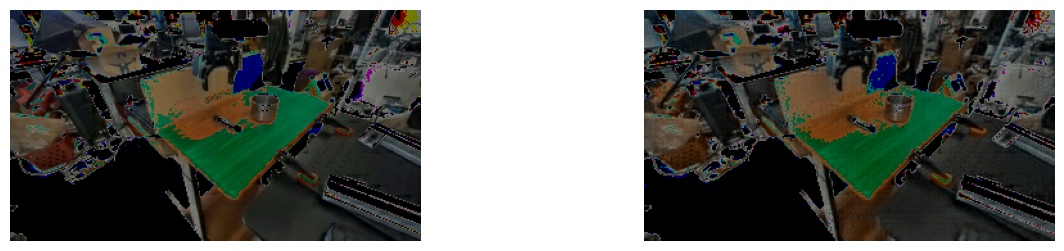

In [8]:
from autoencoder import load_model
import matplotlib.pyplot as plt

model = load_model(checkpoint="../checkpoints/lowest_loss_ae.pt")
train_loader = torch.utils.data.DataLoader(original_dataset, batch_size=4, shuffle=True)
test_image = next(iter(train_loader))[:1]
with torch.no_grad():
    reconstructed = model.test(test_image.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

print(denorm_value(test_image[0][0][0]))
print(denorm_value(reconstructed[0][0][0]))
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].imshow(denorm_value(test_image.squeeze()))
axes[0].axis('off')
axes[1].imshow(denorm_value(reconstructed.squeeze()))
axes[1].axis('off')

# @todo Billy can you do this?
we need to encode all the 166 images with the encoder, save the encoded vectors get the residual and write a function that will give us the total size of the models and the encoded vector.